In [1]:
'''
# 추천 시스템 알고리즘
> 추천 시스템은 두 개의 카테고리 값 입력에서 하나의 실수 값 출력을 예측하는 회귀 모형이지만 여러가지 방법으로 예측 성능을 향상시키고 있다.
> 추천 시스템에서 사용되는 알고리즘은 다음과 같다.

1. 베이스라인 모형
2. Collaborative Filtering
    1. Neighborhood Models
        - User-based CF
        - Item-based CF
    2. Latent Factor Models
        - Matrix Factorization
        - SVD
3. Content-Based Recommendation

[추천 시스템](https://datascienceschool.net/view-notebook/fcd3550f11ac4537acec8d18136f2066/)
[교차검증](https://datascienceschool.net/view-notebook/266d699d748847b3a3aa7b9805b846ae/)
'''

'\n'

In [2]:
import surprise
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data = surprise.Dataset.load_builtin('ml-100k')
df = pd.DataFrame(data.raw_ratings, columns=["user", "item", "rate", "id"])
del df["id"]
df.head(10)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /Users/geekdomer/.surprise_data/ml-100k


user item  rate
0  196  242   3.0
1  186  302   3.0
2   22  377   1.0
3  244   51   2.0
4  166  346   1.0
5  298  474   4.0
6  115  265   2.0
7  253  465   5.0
8  305  451   3.0
9    6   86   3.0

In [3]:
df_table = df.set_index(["user", "item"]).unstack()
df_table.shape

(943, 1682)

In [4]:
df_table.iloc[212:222, 808:817].fillna("")

rate                                
item  211 212 213 214 215 216 217 218 219
user                                     
290     3                   4       2    
291         4       4   4           4   4
292                 3                    
293     4       3       4   4   3   2    
294                                      
295             5       5   5   4   5    
296     4                                
297     4       3       2   4       3    
298     5       3       5                
299     4   4   5           5

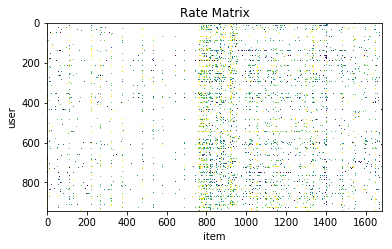

In [6]:
plt.imshow(df_table)
plt.grid(False)
plt.xlabel("item")
plt.ylabel("user")
plt.title("Rate Matrix")
plt.show()

In [8]:
# # 베이스라인 모형
# SGD (Stochastic Gradient Descent)의 인수
# - reg: 정규화 가중치. 디폴트는 0.02.
# - learning_rate: 최적화 스텝 사이즈. 디폴트는 0.005.
# - n_epochs: 최적화 반복 횟수. 디폴트는 20.
# ALS (Alternating Least Squares)의 인수
# - reg_i: 상품에 대한 정규화 가중치. 디폴트는 10.
# - reg_u: 사용자에 대한 정규화 가중치. 디폴트는 15.
# - n_epochs: 최적화 반복 횟수. 디폴트는 10.
bsl_options = {
    'method': 'als',
    'n_epochs': 5,
    'reg_u': 12,
    'reg_i': 5
}
algo = surprise.BaselineOnly(bsl_options)
algo

In [9]:
# # 추천성능 평가기준
# accuracy 서브패키지에서는 다음과 같은 추천성능 평가기준을 제공한다. 이 식에서  𝑅̂  은 테스트 데이터셋을 뜻한다.
# - RMSE (Root Mean Squared Error)
# - MAE (Mean Absolute Error)
# - FCP (Fraction of Concordant Pairs)

from surprise.model_selection import KFold
np.random.seed(0)
acc = np.zeros(3)
cv = KFold(3)
# print(len(data.raw_ratings))
for i, (trainset, testset) in enumerate(cv.split(data)):
    algo.fit(trainset)
    predictions = algo.test(testset)
    acc[i] = surprise.accuracy.rmse(predictions, verbose=True)
acc.mean()

Estimating biases using als...
RMSE: 0.9453
Estimating biases using als...
RMSE: 0.9377
Estimating biases using als...
RMSE: 0.9500


0.9443304984013942

In [10]:
from surprise.model_selection import cross_validate
cross_validate(algo, data)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'fit_time': (0.26017212867736816,
  0.2946341037750244,
  0.30895209312438965,
  0.30844712257385254,
  0.31629514694213867),
 'test_mae': array([0.74477853, 0.75124267, 0.73975393, 0.745764  , 0.74659098]),
 'test_rmse': array([0.9384446 , 0.94651657, 0.93612815, 0.94221861, 0.94428787]),
 'test_time': (0.3445758819580078,
  0.47014594078063965,
  0.4376401901245117,
  0.4653329849243164,
  0.3517460823059082)}

In [13]:
# # 유사도 계산
# 사용자 특성 벡터(평점 행렬의 행 벡터)이나 상품 특성 벡터(평점 행렬의 열 벡터)의 유사도(similarity)을 비교하기 위한 기준도 여러가지가 있을 수 있다.
# ## surprise 패키지에서는 다음과 같은 유사도 기준을 제공한다.
# - 평균제곱차이 유사도 (Mean Squared Difference Similarity)
# - 코사인 유사도 (Cosine Similarity)
# - 피어슨 유사도 (Pearson Similarity)
# - 피어슨-베이스라인 유사도 (Pearson-Baseline Similarity)
sim_options = {'name': 'msd'}
algo = surprise.KNNBasic(sim_options=sim_options)
for i, (trainset, testset) in enumerate(cv.split(data)):
    algo.fit(trainset)
    predictions = algo.test(testset)
    acc[i] = surprise.accuracy.rmse(predictions, verbose=True)
acc.mean()
# cross_validate(algo, data)["test_mae"].mean()

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9873
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9911
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9885


0.9889661666874917

In [35]:
cv = KFold(1)
sim_options = {'name': 'msd'}
algo = surprise.KNNBasic(sim_options=sim_options)
# (trainset, testset) = cv.split(data)
for i, (trainset, testset) in enumerate(cv.split(data)):
    print(i)
#     print(trainset)
# algo.fit(trainset)
# predictions = algo.test(testset)
# surprise.accuracy.rmse(predictions, verbose=True)

ValueError: Incorrect value for n_splits=100000. Must be >=2 and less than the number of ratings

In [46]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader


# Creation of the dataframe. Column names are irrelevant.
ratings_dict = {'itemID': [1, 1, 1, 2, 2],
                'userID': [9, 32, 2, 45, 'user_foo'],
                'rating': [3, 2, 4, 3, 1]}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
# data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)
data

TypeError: 'DatasetAutoFolds' object is not subscriptable